In [2]:
import os
import sys
import numpy as np
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import pixel as pix
import utilities as util
import tile
import importlib
import resnet as rs
import keras
from keras.optimizers import Adam
importlib.reload(tile)

<module 'tile' from '/host/Desktop/cnn_dev/florence_mapping/tile.py'>

In [3]:
landsat, sentinel, dem, label = util.load_data()
tile_size = 64
num_classes = util.get_class_count()
pixel_gen = pix.pixel_gen(landsat, sentinel, dem, label, tile_size, num_classes)
tile_gen = tile.tile_gen(landsat, sentinel, dem, label, tile_size, num_classes)

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="3";

In [5]:
pixels = pixel_gen.gen_pixels(1000000, balanced=True)
train_px, test_px, val_px = pixel_gen.train_val_test_split(pixels, 0.7, 0.7)
pixel_gen.print_balance()

pixels generated 742582
train:519807 val:155942 test:113616
Water:57222.0
Snow/Ice:0.0
Open Space Developed:62500.0
Low Intensity Developed:0.0
Medium Intensity Developed:62500.0
High Intensity Developed:0.0
Barren Land:53980.0
Deciduous Forest:50144.0
Evergreen Forest:62500.0
Mixed Forest:50420.0
Scrub/Shrub:53823.0
Grassland / Herbaceous:51993.0
Pasture/Hay:50000.0
Cultivated Land:62500.0
Woody Wetland:62500.0
Emergent Herbaceous Wetlands:62500.0


In [6]:
epochs = 20
batch_size = 25
input_shape = tile_gen.get_tile_shape(reshape=True)
print(input_shape)

(10, 64, 64)


In [7]:
#model = rs.ResnetBuilder.build_resnet_101(input_shape,num_classes)

In [18]:
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit_generator(generator=tile_gen.tile_generator(train_px, batch_size), 
                    steps_per_epoch=len(train_px) // batch_size, epochs=epochs, verbose=1,
                    validation_data=tile_gen.tile_generator(val_px, batch_size),
                    validation_steps=len(val_px) // batch_size)

Epoch 1/20
10156/20792 [=============>................] - ETA: 2:10:10 - loss: 1.1748 - acc: 0.6187

KeyboardInterrupt: 

In [21]:
model.save('resnet_1.h5')

# Test Pixels

2436/2436 [==============================] - 602s 247ms/step
Accuracy is 0.6056611761083743


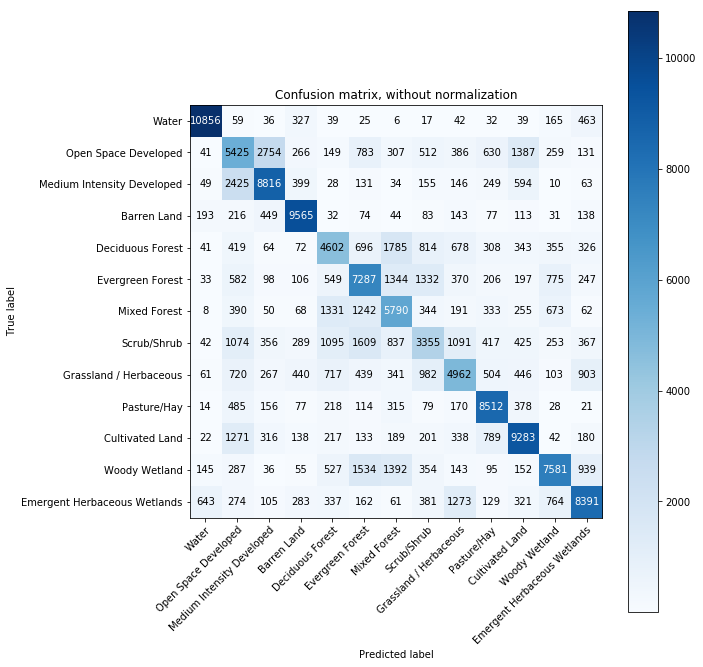

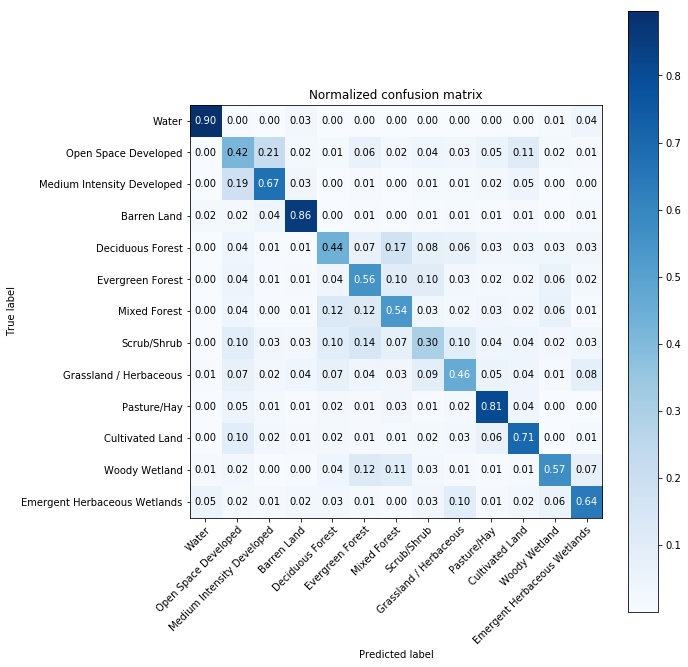

In [22]:
tile_gen.evaluate_cnn(model, test_px)

# Test Pixels on specific tiles

In [23]:
pixel_buckets = { 0: list(), 1: list(), 2: list(), 3: list(), 4: list()}
for pix in test_px:
    pixel_buckets[pix[1]].append(pix)

# Tile 0

532/532 [==============================] - 132s 249ms/step
Accuracy is 0.5692551691729323


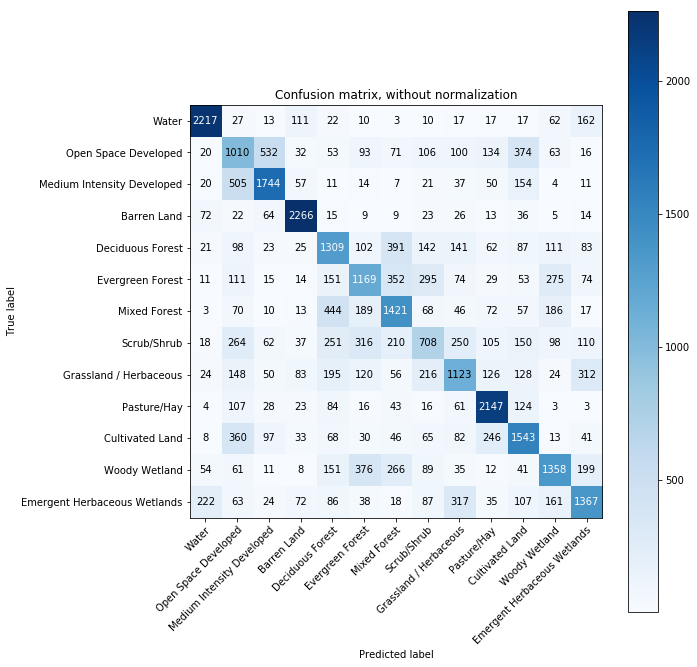

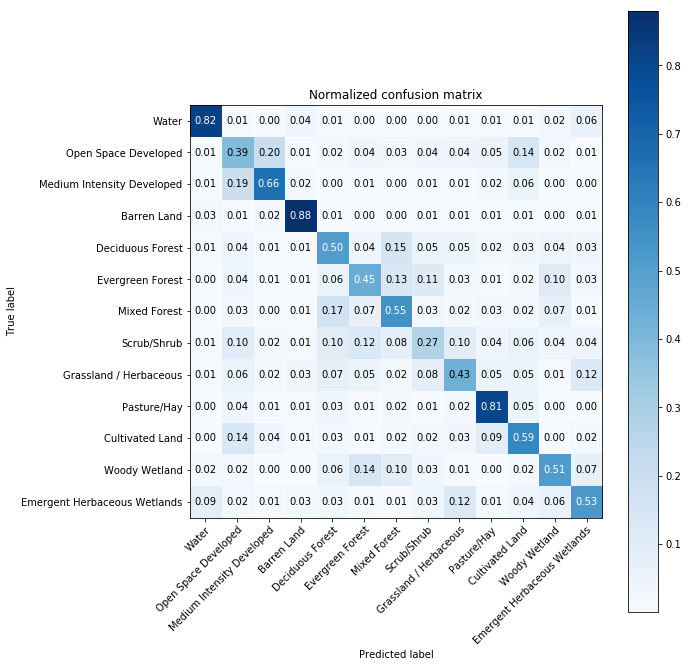

In [24]:
tile_gen.evaluate_cnn(model, pixel_buckets[0])

# Tile 1

490/490 [==============================] - 122s 249ms/step
Accuracy is 0.5481186224489796


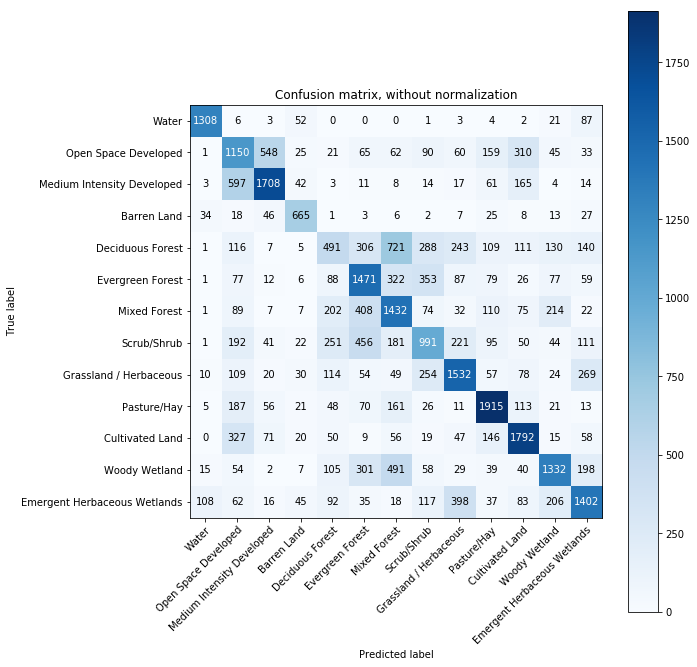

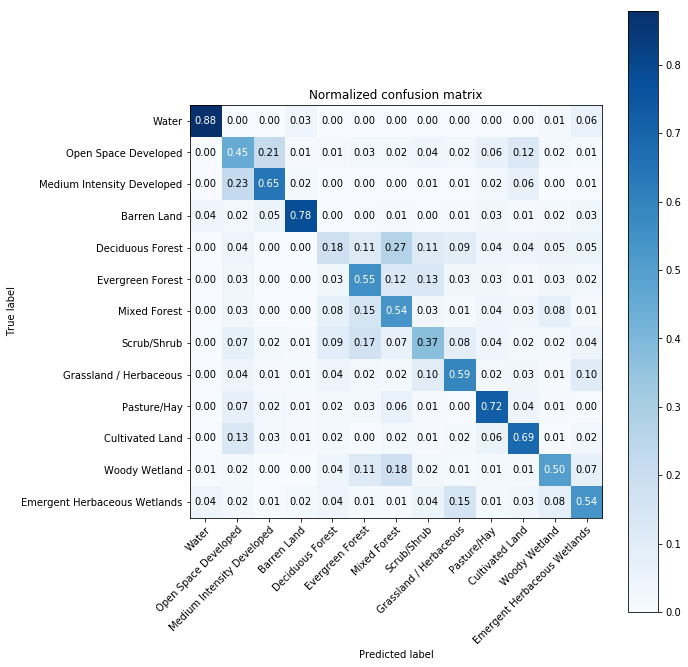

In [25]:
tile_gen.evaluate_cnn(model, pixel_buckets[1])

# Tile 2

532/532 [==============================] - 133s 249ms/step
Accuracy is 0.565172697368421


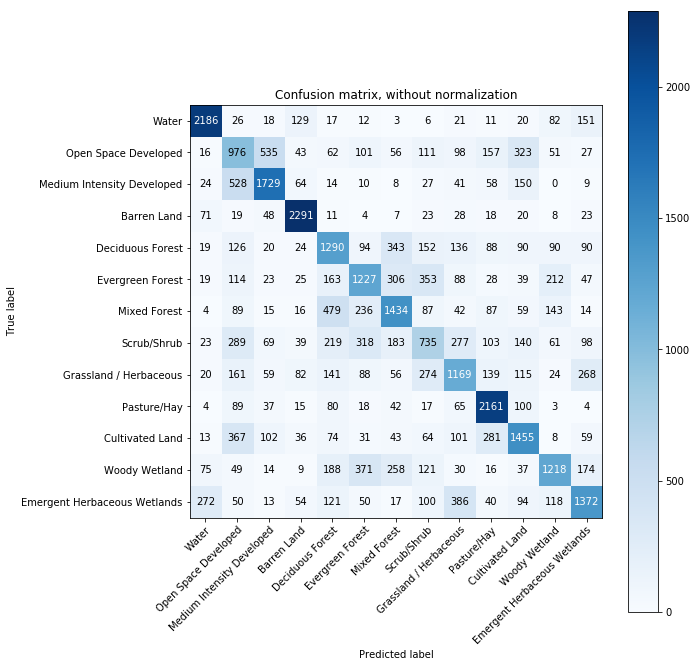

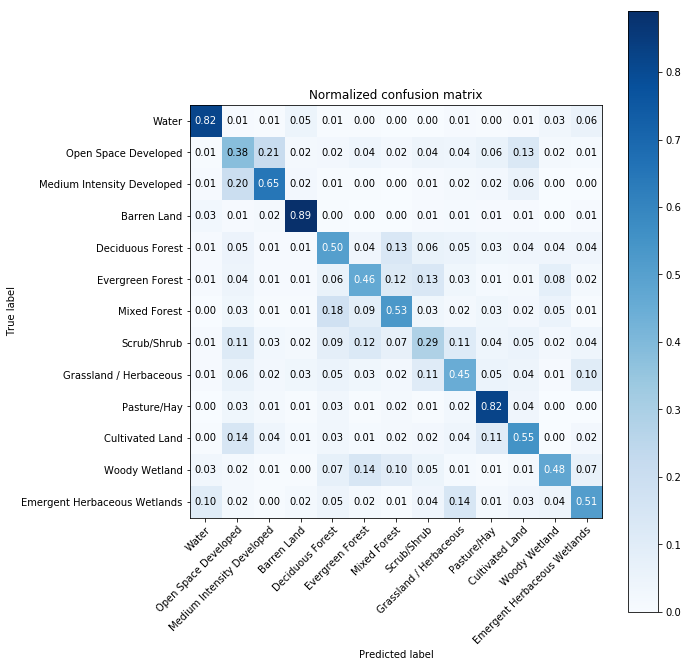

In [26]:
tile_gen.evaluate_cnn(model, pixel_buckets[2])

# Tile 3

532/532 [==============================] - 132s 248ms/step
Accuracy is 0.6175986842105263


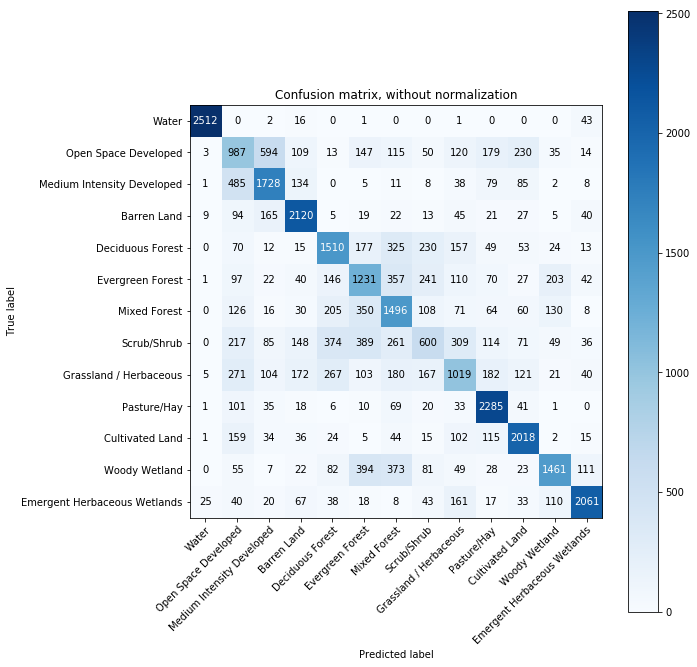

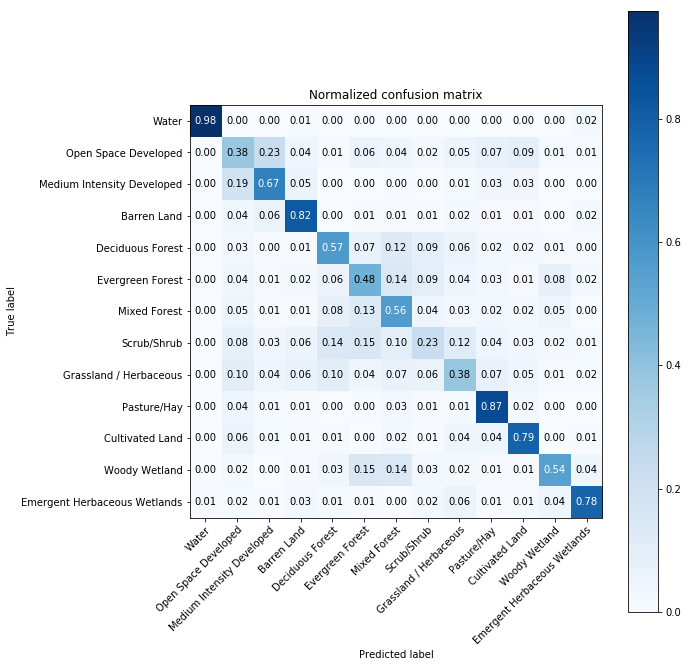

In [27]:
tile_gen.evaluate_cnn(model, pixel_buckets[3])

# Tile 4

348/348 [==============================] - 86s 247ms/step


/host/Desktop/cnn_dev/florence_mapping/utilities.py:114: RuntimeWarning: invalid value encountered in true_divide
  cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


Accuracy is 0.7863236350574713


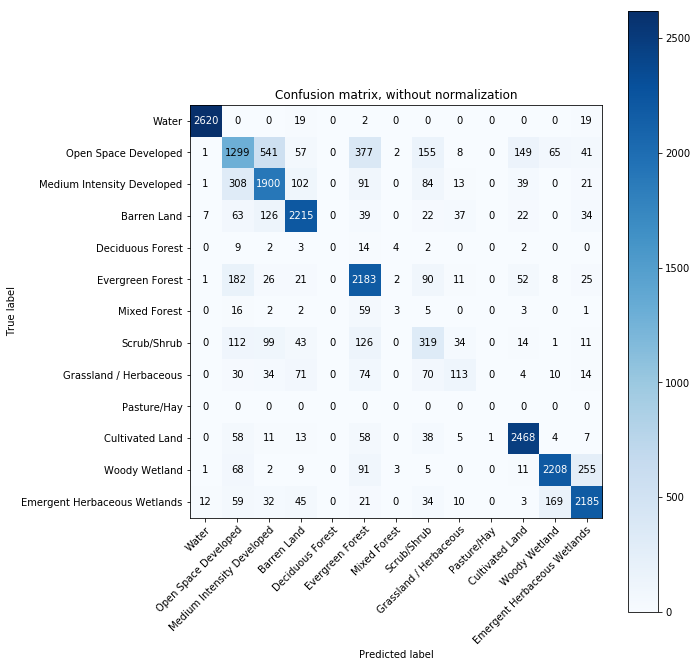

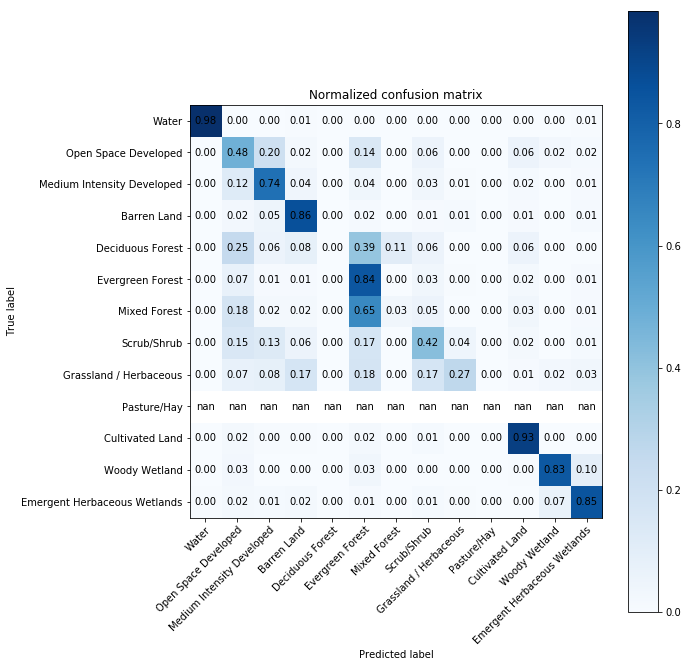

In [28]:
tile_gen.evaluate_cnn(model, pixel_buckets[4])